In [121]:
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt

# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [122]:
X_train = np.load('X_train_surge.npz')
Y_train = pd.read_csv('Y_train_surge.csv')
X_test = np.load('X_test_surge.npz')

In [123]:
surge_train = np.array(Y_train)[:,1:]

In [124]:
def surge_prediction_metric(dataframe_y_true, dataframe_y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    surge1_columns = [
        'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
        'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]
    surge2_columns = [
        'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3', 'surge2_t4',
        'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8', 'surge2_t9' ]
    surge1_score = (weights * (dataframe_y_true[surge1_columns].values - dataframe_y_pred[surge1_columns].values)**2).mean()
    surge2_score = (weights * (dataframe_y_true[surge2_columns].values - dataframe_y_pred[surge2_columns].values)**2).mean()

    return surge1_score + surge2_score

In [125]:
def time_elapsed_hour(time_1, time_2):
    return (time_2-time_1)/(3600)

In [126]:
slp_train = X_train['slp']
t_slp_train = X_train['t_slp']
t_surge1_input_train = X_train['t_surge1_input']
t_surge2_input_train = X_train['t_surge2_input']
surge1_input_train = X_train['surge1_input']
surge2_input_train = X_train['surge2_input']
t_surge1_output_train = X_train['t_surge1_output']
t_surge2_output_train = X_train['t_surge2_output']

In [127]:
def format_t(data):
    new_set = set()
    for j in data:
        for i in j:
            new_set.add(i)
    new_set=sorted(list(new_set))
    return new_set
    
    
def format_(data, t_data, t_set):
    new_set = np.zeros(len(t_set))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            a = data[i][j]
            b = t_data[i][j]
            c = t_set.index(b)
            new_set[c] = a
    return new_set

In [128]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [129]:
t_slp_train_set = format_t(t_slp_train)
slp_train_set = np.zeros([len(t_slp_train_set), 1681])
for i in range(slp_train.shape[0]):
    for j in range(slp_train.shape[1]):
        t = t_slp_train[i][j]
        t_new = t_slp_train_set.index(t)
        slp_train_set[t_new] = np.ndarray.flatten(slp_train[i][j]) 

In [104]:
i = 0
length = 5000 #len(t_slp_train_set)-1
for j in range(length):
    if time_elapsed_hour(t_slp_train_set[j], t_slp_train_set[j+1])>3.5:
        dataset = slp_train_set[i:j+1]
        n_steps_in, n_steps_out = 4, 3
        # covert into input/output
        X_new, y_new = split_sequences(dataset, n_steps_in, n_steps_out)   
        if i == 0:
            X = np.array(X_new)
            y = np.array(y_new)
        else:
            X = np.concatenate([X, X_new], axis=0) 
            y = np.concatenate([y, y_new], axis=0) 
        i = j + 1
        print(j)
    else:
        continue 
    

122
245
367
490
613
735
857
979
1102
1225
1348
1471
1594
1717
1841
1964
2087
2210
2333
2457
2580
2703
2825
2948
3071
3194
3316
3438
3561
3684
3807
3930
4053
4176
4298
4421
4544
4668
4790
4912
5034
5157
5280
5403
5527
5650
5772
5896
6019
6142
6265
6388
6510
6632
6754
6876
6998
7121
7244
7367
7490
7613
7736
7859
7982
8105
8228
8351
8474
8596
8718
8841
8964
9087
9210
9333
9456
9578
9701
9824
9947
10069
10192
10315
10438
10561
10684
10807
10930
11052
11174
11296
11419
11542
11665
11788
11911
12033
12156
12279
12402
12525
12647
12769
12891
13014
13137
13260
13383
13505
13627
13749
13871
13994
14117
14240
14364
14486
14609
14732
14855
14978
15101
15224
15347
15470
15593
15716
15838
15961
16084
16207
16330
16453
16576
16699
16822
16944
17067
17190
17313
17436
17559
17682
17805
17928
18051
18174
18297
18419
18543
18666
18789
18912
19034
19156
19279
19401
19524
19647
19770
19893


In [91]:
X.shape

(8652, 12, 1681)

In [105]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
#model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
577/577 [==============================] - 26s 36ms/step - loss: 1226449024.0000
Epoch 2/200
577/577 [==============================] - 21s 36ms/step - loss: 1439793.0000
Epoch 3/200
577/577 [==============================] - 21s 37ms/step - loss: 926072.6875
Epoch 4/200
577/577 [==============================] - 21s 36ms/step - loss: 862255.8750
Epoch 5/200
577/577 [==============================] - 20s 35ms/step - loss: 835383.0625
Epoch 6/200
577/577 [==============================] - 19s 33ms/step - loss: 822005.6875
Epoch 7/200
577/577 [==============================] - 20s 35ms/step - loss: 814261.1250
Epoch 8/200
577/577 [==============================] - 19s 33ms/step - loss: 817135.8125
Epoch 9/200
577/577 [==============================] - 19s 32ms/step - loss: 831150.9375
Epoch 10/200
577/577 [==============================] - 18s 31ms/step - loss: 847811.3750
Epoch 11/200
577/577 [==============================] - 18s 32ms/step - loss: 873455.1875
Epoch 12/200
5

KeyboardInterrupt: 

In [106]:
# demonstrate prediction
x_input = X[0:3]
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=1)
print(yhat)

1/1 [==============================] - 15s 15s/step
[[[103057.695 102978.47  102969.71  ... 101689.51  101660.5   101585.39 ]
  [103045.73  102975.75  102968.914 ... 101688.086 101676.586 101634.1  ]
  [103051.266 102980.375 102971.81  ... 101695.28  101679.88  101634.36 ]
  [103051.05  102980.45  102971.95  ... 101695.19  101680.29  101634.93 ]
  [103051.08  102980.46  102971.945 ... 101695.2   101680.25  101634.88 ]]

 [[103059.41  102980.18  102971.42  ... 101691.195 101662.19  101587.08 ]
  [103047.44  102977.46  102970.625 ... 101689.77  101678.266 101635.79 ]
  [103052.984 102982.09  102973.52  ... 101696.98  101681.58  101636.055]
  [103052.76  102982.164 102973.66  ... 101696.875 101681.97  101636.62 ]
  [103052.8   102982.17  102973.66  ... 101696.89  101681.94  101636.57 ]]

 [[103040.125 102960.92  102952.164 ... 101672.18  101643.164 101568.07 ]
  [103028.16  102958.195 102951.36  ... 101670.76  101659.25  101616.77 ]
  [103033.71  102962.83  102954.266 ... 101677.945 10166

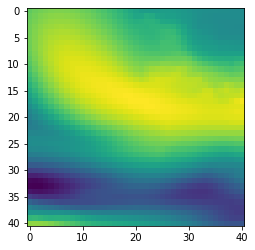

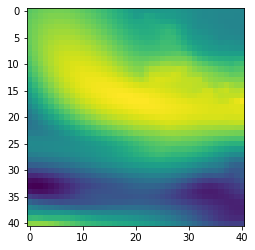

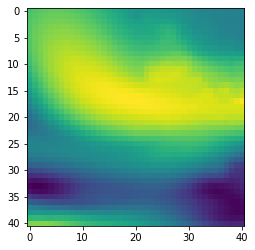

In [107]:
for j in range(3):
    plt.imshow(x_input[0][j].reshape(41,41))
    plt.show()

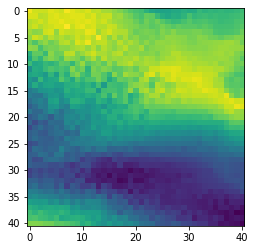

In [119]:
plt.imshow(yhat[0][3].reshape(41,41))

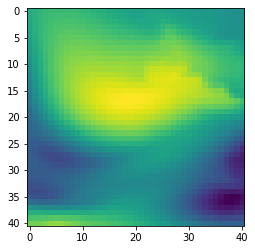

In [120]:
plt.imshow(y[0][3].reshape(41,41))